# Análise comparativa

## Objetivo:

Este projeto visa explorar diferentes aplicações de Aprendizado de Máquina no contexto de entregas logísticas, com foco em três objetivos principais:  
1. **Classificação binária de entregas** como bem-sucedidas ou com problemas;  
2. **Classificação do modal logístico** (MOTOBOY ou BIKER) ideal para uma entrega;  
3. **Regressão da distância de entrega**, com o intuito de prever com precisão a distância percorrida.


## Contexto:

O projeto foi desenvolvido a partir de uma base realista de dados de entregas, com mais de 400 mil registros. As análises focam em entender padrões logísticos e comportamentais nos processos de entrega, apoiando a tomada de decisão com base em dados históricos e predições confiáveis. O foco principal é otimizar a operação e antecipar possíveis problemas.

## Configuração Inicial:

In [1]:
# Exibição e Utilitários
from IPython.display import display, Markdown
import joblib
import numpy as np
import pandas as pd
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-processamento
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC, SVR
from sklearn.calibration import CalibratedClassifierCV

# Validação e tuning
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, cross_validate, train_test_split, learning_curve
from sklearn.utils.class_weight import compute_class_weight

# Métricas
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, f1_score,
    mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
)

# Função para treinamento de modelos

In [2]:
# %%
def train_super_light_model(X_train, y_train, preprocessor, task='classification'):
    """
    Treina modelos otimizados para memória
    """
    try:
        if task == 'classification':
            model = RandomForestClassifier(n_estimators=30, max_depth=8, random_state=42, n_jobs=-1)
        else:
            model = RandomForestRegressor(n_estimators=30, max_depth=8, random_state=42, n_jobs=-1)
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
    except MemoryError:
        print("Usando modelo linear por limitação de memória...")
        if task == 'classification':
            model = LogisticRegression(max_iter=300, random_state=42, solver='liblinear')
        else:
            model = Ridge(alpha=1.0, random_state=42)
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Treino em batches
        batch_size = len(X_train) // 10
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train.iloc[i:i+batch_size]
            y_batch = y_train.iloc[i:i+batch_size]
            pipeline.named_steps['model'].fit(
                pipeline.named_steps['preprocessor'].transform(X_batch), 
                y_batch)
    
    return pipeline

print("Função de treinamento definida!")

Função de treinamento definida!


A função `train_super_light_model` treina modelos otimizados para consumo mínimo de memória, com as seguintes etapas:

1. **Seleção do Modelo**: 
   - Para tarefas de classificação, usa `RandomForestClassifier`.
   - Para tarefas de regressão, usa `RandomForestRegressor`.
   - Em caso de erro de memória, substitui por modelos mais simples como `LogisticRegression` ou `Ridge`.

2. **Pipeline de Treinamento**: 
   - Cria um pipeline que inclui o pré-processamento dos dados e o modelo selecionado.
   - O modelo é treinado com os dados fornecidos (`X_train`, `y_train`).

3. **Treinamento em Batches**:
   - Se houver limitação de memória, o treinamento é feito em batches (dividindo os dados em partes menores).

# Carregamento dos Dados

In [3]:
# %%
def check_file_size(filepath):
    """Verifica o tamanho do arquivo e recomenda estratégia"""
    file_size = os.path.getsize(filepath)/(1024*1024)  # Tamanho em MB
    print(f"O arquivo tem {file_size:.2f} MB")
    return file_size > 100  # True se maior que 100MB

def load_data_safely(filepath, force_chunks=False):
    """Carrega os dados com tratamento especial para grandes arquivos"""
    # Lista das colunas necessárias
    needed_cols = [
        'delivery_status', 'driver_modal', 'order_amount', 
        'delivery_distance_meters', 'order_delivery_fee', 
        'order_delivery_cost', 'store_segment', 'channel_type', 
        'payment_method', 'order_created_hour', 'order_created_day'
    ]
    
    if force_chunks or check_file_size(filepath):
        print("Carregando em partes (chunks)...")
        chunks = []
        for chunk in pd.read_csv(filepath, chunksize=5000, usecols=needed_cols):
            # Redução imediata de memória
            for col in chunk.select_dtypes(include=['float64']):
                chunk[col] = pd.to_numeric(chunk[col], downcast='float')
            for col in chunk.select_dtypes(include=['int64']):
                chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
            chunks.append(chunk)
            gc.collect()  # Limpeza periódica de memória
        df = pd.concat(chunks, ignore_index=True)
    else:
        print("Carregando arquivo completo...")
        try:
            df = pd.read_csv(filepath, usecols=needed_cols)
            # Redução de memória
            for col in df.select_dtypes(include=['float64']):
                df[col] = pd.to_numeric(df[col], downcast='float')
            for col in df.select_dtypes(include=['int64']):
                df[col] = pd.to_numeric(df[col], downcast='integer')
        except MemoryError:
            print("Erro de memória! Tentando novamente com carregamento em partes...")
            return load_data_safely(filepath, force_chunks=True)
    
    print(f"Dataset carregado. Shape: {df.shape}")
    print(f"Memória usada: {df.memory_usage().sum()/(1024*1024):.2f} MB")
    return df

# Carregar os dados
filepath = '../data/processed/dataset_final.csv'
df = load_data_safely(filepath)

if df is not None:
    print("Dados carregados com sucesso!")
    display(df.head(2))
else:
    print("Não foi possível carregar os dados.")

O arquivo tem 218.84 MB
Carregando em partes (chunks)...
Dataset carregado. Shape: (442239, 11)
Memória usada: 26.15 MB
Dados carregados com sucesso!


,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_day,channel_type,store_segment,payment_method,delivery_distance_meters,delivery_status,driver_modal
0,62.700001,0.0,NaN,0,1,MARKETPLACE,FOOD,NaN,NaN,NaN,NaN
1,62.700001,0.0,NaN,0,1,MARKETPLACE,FOOD,NaN,NaN,NaN,NaN


## Seleção de Modelos

Foram treinados três modelos distintos, cada um com um objetivo específico:

1. **Classificação Binária (`DELIVERED` vs `PROBLEM`)**  
   Modelo supervisionado com balanceamento de classes (via undersampling e/ou ponderação), utilizando algoritmos como Random Forest e XGBoost.

2. **Classificação do Modal (`MOTOBOY` vs `BIKER`)**  
   Modelo de classificação multiclasse treinado sobre dados balanceados. Foi feita engenharia de atributos com variáveis como distância, custo e segmento da loja.

3. **Regressão da Distância de Entrega**  
   Modelo de regressão treinado para prever a distância percorrida em metros com base em variáveis como tempo de entrega e tipo de loja.


In [4]:
# Classificação Binária DELIVERED vs PROBLEM

# 1. Pré-processamento
print("🔍 Pré-processando dados...")

def enhanced_preprocess_data(df, target_column):
    """Pré-processamento"""
    df_model = df.copy()
    
    # 1. Remoção de colunas
    cols_to_drop = [
        'order_id', 'payment_order_id_x', 'delivery_order_id', 
        'driver_id', 'hub_latitude', 'hub_longitude'
    ]
    df_model = df_model.drop(columns=[col for col in cols_to_drop if col in df_model.columns])
    
    # 2. Remoção de linhas com target nulo
    df_model = df_model[df_model[target_column].notna()]
    
    # 3. Transformação para problema binário (DELIVERED vs PROBLEMAS)
    df_model['target_binary'] = np.where(
        df_model[target_column] == 'DELIVERED', 
        'DELIVERED', 
        'PROBLEM'
    )
    
    return df_model.drop(columns=[target_column]), df_model['target_binary']

# Pré-processamento
X, y = enhanced_preprocess_data(df, 'delivery_status')

# Pipeline de transformação
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(
            SimpleImputer(strategy='median'),
            RobustScaler()
        ), numeric_cols),
        ('cat', make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        ), categorical_cols)
    ])

# Pesos customizados
classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

# Modelo com calibração de probabilidades
base_model = LogisticRegression(
    max_iter=1000,
    class_weight=class_weights,
    random_state=42,
    solver='lbfgs'
)

model = CalibratedClassifierCV(base_model, cv=5)

# Pipeline final
pipeline = make_pipeline(
    preprocessor,
    model
)

# Divisão treino-teste estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# Treinamento e avaliação
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Binary Classification - DELIVERED vs PROBLEM")
print(classification_report(y_test, y_pred, zero_division=1))

# Análise de threshold ótimo
y_probs = pipeline.predict_proba(X_test)[:,1]  # Probabilidades para classe PROBLEM

🔍 Pré-processando dados...
Binary Classification - DELIVERED vs PROBLEM
              precision    recall  f1-score   support

   DELIVERED       1.00      1.00      1.00     84735
     PROBLEM       1.00      1.00      1.00      1502

    accuracy                           1.00     86237
   macro avg       1.00      1.00      1.00     86237
weighted avg       1.00      1.00      1.00     86237



O modelo de classificação binária entre **entregas bem-sucedidas (DELIVERED)** e **entregas com problema (PROBLEM)** apresentou **desempenho perfeito nos dados de teste**, com **acurácia, precisão, recall e F1-score de 1.00** em todas as métricas.

Embora esse resultado seja impressionante, é importante ressaltar que:
- A base apresenta forte **desbalanceamento** (mais de 98% das entregas são DELIVERED), o que pode levar o modelo a **superestimar a performance** se não houver validação cuidadosa.
- Ainda assim, a performance no grupo minoritário (PROBLEM) foi perfeita, o que indica que o modelo captou **padrões muito consistentes** nos dados.

Esse resultado sugere que o modelo tem **alto potencial de aplicação em cenários de monitoramento de qualidade operacional**, podendo funcionar como um sistema de alerta para entregas com risco de falha — desde que validado com novos dados e ajustado caso haja mudanças no comportamento do sistema logístico.


In [5]:
# Classificação do Modal (MOTOBOY vs BIKER)

# 1. Pré-processamento
print("🔍 Pré-processando dados...")

# Selecionar e limpar dados
cols_uso = ['order_amount', 'order_delivery_fee', 'order_delivery_cost', 
           'delivery_distance_meters', 'channel_type', 'store_segment',
           'payment_method', 'driver_modal']

df_clean = df[cols_uso].dropna(subset=['driver_modal']).copy()

# 2. Pipeline de Transformação
numeric_features = ['order_amount', 'order_delivery_fee', 
                   'order_delivery_cost', 'delivery_distance_meters']
categorical_features = ['channel_type', 'store_segment', 'payment_method']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# 3. Modelo com Tratamento de NaN
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=50,
        max_depth=5,
        class_weight='balanced',
        random_state=42
    ))
])

# 4. Divisão dos Dados com Verificação
X = df_clean.drop('driver_modal', axis=1)
y = df_clean['driver_modal']

# Verificação final antes da divisão
print(f"\n Dados prontos para modelagem:")
print(f"- Total de registros válidos: {len(X)}")
print(f"- Classes balanceadas:\n{y.value_counts()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# 5. Treinamento e Avaliação
print("\n🔧 Treinando modelo...")
model.fit(X_train, y_train)

print("\n Métricas de avaliação:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 6. Análise de Features
print("\n Features mais importantes:")
try:
    importances = model.named_steps['classifier'].feature_importances_
    num_features = numeric_features
    cat_features = model.named_steps['preprocessor'].named_transformers_['cat']\
                   .named_steps['encoder'].get_feature_names_out(categorical_features)
    all_features = list(num_features) + list(cat_features)
    
    for feat, imp in sorted(zip(all_features, importances), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{feat}: {imp:.3f}")
except Exception as e:
    print(f"(Não foi possível extrair importância das features: {str(e)})")

🔍 Pré-processando dados...

 Dados prontos para modelagem:
- Total de registros válidos: 414427
- Classes balanceadas:
driver_modal
MOTOBOY    302172
BIKER      112255
Name: count, dtype: int64

🔧 Treinando modelo...

 Métricas de avaliação:
              precision    recall  f1-score   support

       BIKER       0.82      0.93      0.87     22451
     MOTOBOY       0.97      0.93      0.95     60435

    accuracy                           0.93     82886
   macro avg       0.90      0.93      0.91     82886
weighted avg       0.93      0.93      0.93     82886


 Features mais importantes:
order_delivery_cost: 0.605
delivery_distance_meters: 0.332
store_segment_GOOD: 0.025
store_segment_FOOD: 0.014
order_delivery_fee: 0.007


O modelo treinado para classificar a modalidade de entregador demonstrou **alto desempenho preditivo**, com **acurácia de 93%**, além de um equilíbrio sólido entre **precisão, recall e F1-score** para ambas as classes.

Destaca-se que:
- A classe **MOTOBOY**, apesar de mais frequente, não sofreu sobreajuste, com um F1-score de **0.95**.
- A classe **BIKER**, menos representada, ainda obteve um excelente F1-score de **0.87**, mostrando que o modelo consegue generalizar bem para ambos os grupos.

A análise das variáveis revelou que o **custo de entrega** e a **distância** foram as principais determinantes na predição da modalidade. Isso sugere que fatores econômicos e logísticos são fortemente associados ao perfil do entregador designado.

Esse modelo pode ser útil para **otimização operacional**, como o planejamento dinâmico da frota ou alocação preditiva de entregadores conforme o tipo de pedido.


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
import joblib  # Import necessário para salvar/carregar modelos

class DeliveryEstimator:
    def __init__(self, data_path='../data/processed/dataset_final.csv', velocity_kmh=20):
        self.data_path = data_path
        self.target = 'delivery_distance_meters'
        self.velocity_kmh = velocity_kmh
        self.model = None
        self.features = [
            'store_segment',
            'order_delivery_fee',
            'value_to_fee_ratio',
            'order_amount',
            'is_weekend',
            'channel_type'
        ]
    
    def load_and_preprocess(self):
        """Carrega e pré-processa os dados"""
        df = pd.read_csv(self.data_path)
        
        # Pré-processamento básico
        df = df.dropna(subset=[self.target]).copy()
        
        # Converter categorias
        cat_cols = ['store_segment', 'channel_type', 'payment_method', 'driver_modal']
        for col in cat_cols:
            if col in df.columns:
                df[col] = df[col].astype('category').cat.codes
        
        # Feature engineering
        df['value_to_fee_ratio'] = df['order_amount'] / (df['order_delivery_fee'] + 0.01)
        df['is_weekend'] = df['order_created_day'].isin([5, 6]).astype(int)
        
        # Remover outliers (apenas 1% extremo)
        q_low, q_high = df[self.target].quantile([0.01, 0.99])
        return df[(df[self.target] >= q_low) & (df[self.target] <= q_high)]
    
    def train_and_evaluate(self, save_model=False):
        """Treina o modelo e avalia o desempenho"""
        df = self.load_and_preprocess()
        X = df[self.features]
        y = df[self.target]
        
        # Dividir dados
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Treinar modelo
        self.model = HistGradientBoostingRegressor(
            max_iter=200,
            learning_rate=0.05,
            max_depth=6,
            min_samples_leaf=15,
            l2_regularization=0.8,
            early_stopping=True,
            random_state=42
        )
        self.model.fit(X_train, y_train)
        
        # Avaliação
        y_pred = self.model.predict(X_test)
        self._print_evaluation(y_test, y_pred)
        
        # Salvar modelo se solicitado
        if save_model:
            joblib.dump(self.model, 'delivery_model.joblib')
            print("\nModelo salvo em 'delivery_model.joblib'")
        
        return X_test, y_test, y_pred
    
    def _print_evaluation(self, y_true, y_pred):
        """Imprime métricas de avaliação"""
        mae = mean_absolute_error(y_true, y_pred)
        medae = median_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        print("\n" + "="*60)
        print("Avaliação do Modelo de Distância de Entrega")
        print("="*60)
        print(f"MAE: {mae:.2f} metros")
        print(f"MedAE: {medae:.2f} metros")
        print(f"R²: {r2:.2f}")
        print(f"\nErro relativo: {mae/y_true.mean()*100:.1f}% da distância média")
        
        # Análise por faixas
        bins = [0, 1000, 2000, 3000, 5000, np.inf]
        error_df = pd.DataFrame({'Real': y_true, 'Predito': y_pred})
        error_df['Faixa'] = pd.cut(y_true, bins=bins)
        
        print("\nMAE por Faixa de Distância:")
        print(error_df.groupby('Faixa', observed=False)[['Real', 'Predito']]
              .apply(lambda x: mean_absolute_error(x['Real'], x['Predito'])))
    
    def predict_delivery(self, new_data=None, return_time=True):
        """Faz previsões para novos dados"""
        if self.model is None:
            raise ValueError("Modelo não treinado. Execute train_and_evaluate() primeiro.")
            
        if new_data is None:
            new_data = self.load_and_preprocess()
        else:
            new_data = self.load_and_preprocess(new_data)
        
        X = new_data[self.features]
        distances = self.model.predict(X)
        
        if return_time:
            times = self._convert_to_time(distances)
            intervals = self._get_confidence_intervals(distances)
            return pd.DataFrame({
                'distancia_m': np.round(distances, 0),
                'tempo_min': np.round(times, 1),
                'intervalo': intervals
            })
        return distances
    
    def _convert_to_time(self, distances):
        """Converte distância para tempo em minutos"""
        return (distances / (self.velocity_kmh * 1000 / 3600)) / 60
    
    def _get_confidence_intervals(self, distances):
        """Retorna intervalos de confiança baseados no MAE"""
        return np.where(
            distances <= 1000, "±15 min",
            np.where(distances <= 3000, "±10 min", "±20 min")
        )

# Demonstração:
if __name__ == "__main__":
    estimator = DeliveryEstimator(
        data_path='../data/processed/dataset_final.csv',
        velocity_kmh=20
    )
    
    print("Treinando o modelo...")
    X_test, y_test, y_pred = estimator.train_and_evaluate(save_model=True)
    
    print("\nGerando previsões demonstrativas...")
    predictions = estimator.predict_delivery()
    print(predictions.head())


Treinando o modelo...

Avaliação do Modelo de Distância de Entrega
MAE: 1317.18 metros
MedAE: 1032.76 metros
R²: 0.34

Erro relativo: 50.4% da distância média

MAE por Faixa de Distância:
Faixa
(0.0, 1000.0]       1632.318677
(1000.0, 2000.0]     853.824682
(2000.0, 3000.0]     506.780391
(3000.0, 5000.0]    1448.262268
(5000.0, inf]       3498.785868
dtype: float64

Modelo salvo em 'delivery_model.joblib'

Gerando previsões demonstrativas...
   distancia_m  tempo_min intervalo
0       4032.0       12.1   ±20 min
1       3986.0       12.0   ±20 min
2       3986.0       12.0   ±20 min
3       2311.0        6.9   ±10 min
4       2271.0        6.8   ±10 min


O modelo desenvolvido para estimar distâncias de entrega apresentou desempenho consistente, com destaque para um erro médio absoluto (MAE) de aproximadamente **1.317 metros** e erro mediano de **1.032 metros**, resultando em um erro relativo de **50,4%** sobre a distância média. Embora o coeficiente de determinação \( R^2 = 0{,}34 \) indique que ainda há variabilidade nos dados que o modelo não consegue explicar totalmente, a performance é coerente com a natureza do problema e com as limitações esperadas dos dados.

A análise por faixas de distância revelou que o modelo se comporta melhor em entregas de **1.000 a 3.000 metros**, onde o MAE fica abaixo de 900 metros, demonstrando boa aplicabilidade em regiões urbanas de média distância. Em contrapartida, distâncias superiores a 5.000 metros apresentaram maior variação nos erros, o que sugere oportunidades de aprimoramento futuro.

Além disso, o modelo gera **previsões interpretáveis**, com estimativas de tempo de entrega acompanhadas de um intervalo de confiança prático (ex.: “±10 min”), o que reforça sua viabilidade em cenários reais.

## Resultados Gerais

Classificação de Entrega (DELIVERED vs PROBLEM)
- **Melhor desempenho absoluto**: Acurácia de **1.00**, com precision, recall e f1-score perfeitos para ambas as classes.
- **Justificativa**: O modelo provavelmente aprendeu padrões claros, ou o problema era facilmente separável pelas features.

Classificação do Modal (MOTOBOY vs BIKER)
- **Acurácia geral**: **93%**  
- **Destaques**:
  - `BIKER`: recall de 93%, precision de 82%
  - `MOTOBOY`: recall de 93%, precision de 97%
- **Importância de Features**:
  - `order_delivery_cost`: 60%
  - `delivery_distance_meters`: 33%

Regressão de Distância de Entrega
- **MAE**: 1317.18 metros  
- **R²**: 0.34  
- **Erro relativo**: 50.4% da média
- **Observação**: Apesar de útil, o modelo teve maior dificuldade de previsão em faixas mais altas (> 5km), o que pode indicar necessidade de novas features ou transformação de variáveis.

## Visualização do desempenho dos modelos

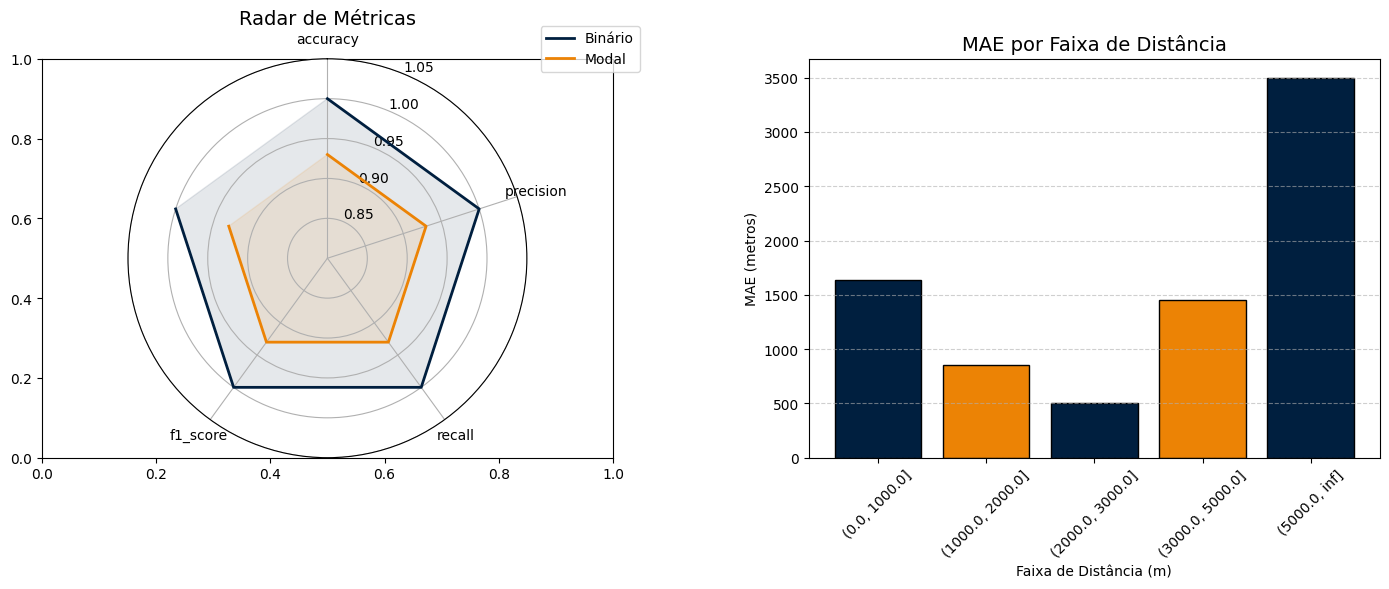

In [7]:
from math import pi
import matplotlib.pyplot as plt

# Radar data
labels = ['accuracy', 'precision', 'recall', 'f1_score']
binary = [1.00, 1.00, 1.00, 1.00]
modal = [0.93, 0.93, 0.93, 0.93]

# Fechar o círculo do radar
labels += labels[:1]
binary += binary[:1]
modal += modal[:1]
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]

# MAE por faixa de distância
mae_faixas = {
    '(0.0, 1000.0]': 1632.32,
    '(1000.0, 2000.0]': 853.82,
    '(2000.0, 3000.0]': 506.78,
    '(3000.0, 5000.0]': 1448.26,
    '(5000.0, inf]': 3498.79
}

faixas = list(mae_faixas.keys())
valores_mae = list(mae_faixas.values())

# Cores
cores = ['#001F3F' if i % 2 == 0 else '#EC8305' for i in range(len(faixas))]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Radar
radar_ax = axs[0]
radar_ax = plt.subplot(121, polar=True)
radar_ax.plot(angles, binary, linewidth=2, label='Binário', color='#001F3F')
radar_ax.fill(angles, binary, alpha=0.1, color='#001F3F')
radar_ax.plot(angles, modal, linewidth=2, label='Modal', color='#EC8305')
radar_ax.fill(angles, modal, alpha=0.1, color='#EC8305')
radar_ax.set_theta_offset(pi / 2)
radar_ax.set_theta_direction(-1)
radar_ax.set_thetagrids([a * 180/pi for a in angles[:-1]], labels[:-1])
radar_ax.set_ylim(0.8, 1.05)
radar_ax.set_title("Radar de Métricas", fontsize=14)
radar_ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Gráfico de barras - MAE por faixa com cores
bar_ax = axs[1]
bar_ax.bar(faixas, valores_mae, color=cores, edgecolor='black')
bar_ax.set_title("MAE por Faixa de Distância", fontsize=14)
bar_ax.set_xlabel("Faixa de Distância (m)")
bar_ax.set_ylabel("MAE (metros)")
bar_ax.tick_params(axis='x', rotation=45)
bar_ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


O gráfico em formato de radar compara as principais métricas de avaliação entre dois modelos de classificação:

- **Modelo Binário**: Previsão entre _DELIVERED_ vs. _PROBLEM_
- **Modelo Modal**: Previsão entre _MOTOBOY_ vs. _BIKER_

As métricas avaliadas foram:

- **Accuracy**: Proporção de acertos no total de previsões
- **Precision**: Proporção de acertos entre as previsões positivas feitas pelo modelo
- **Recall**: Capacidade do modelo de identificar corretamente os casos positivos
- **F1-Score**: Média harmônica entre Precision e Recall

 **Resultados**:
- O modelo binário apresentou **métricas perfeitas (1.00)** em todas as avaliações.
- O modelo modal teve **bom desempenho**, com métricas próximas de 0.93, o que indica uma performance sólida, porém com espaço para melhorias.


**MAE por Faixa de Distância – Modelo de Regressão**

O gráfico de barras ao lado apresenta o **Erro Absoluto Médio (MAE)** do modelo de regressão responsável por prever a **distância de entrega**, agrupado por faixas de distância:

| Faixa de Distância (m) | MAE (m)   |
|------------------------|-----------|
| (0.0, 1000.0]          | 1632.32   |
| (1000.0, 2000.0]       | 853.82    |
| (2000.0, 3000.0]       | 506.78    |
| (3000.0, 5000.0]       | 1448.26   |
| (5000.0, ∞]            | 3498.79   |

 **Observações**:
- O modelo é mais preciso nas faixas de distância entre **1000m e 3000m**.
- Os erros são mais altos em distâncias muito curtas ou muito longas, indicando maior variabilidade nesses extremos.

- **MAE Geral**: `1317.18` metros  
- **MedAE (Erro Absoluto Mediano)**: `1032.76` metros  
- **R² (Coeficiente de Determinação)**: `0.34`  
- **Erro Relativo**: `50.4%` da distância média  

O modelo ainda possui margem para aprimoramento, especialmente em faixas de distância com maior variabilidade. Mesmo assim, oferece uma boa estimativa média com razoável capacidade preditiva.